# Project 3: Predicting Hurricane Damage
### Jackson Thetford and Mihiro Suzuki

## Data preprocessing and visualization

Getting details about the images:

In [1]:
from PIL import Image
image = Image.open('./data/damage/-93.795_30.03779.jpeg')
print("Image Format: ", image.format)
print("Image Mode: ", image.mode)
print("Image Size: ", image.size)


Image Format:  JPEG
Image Mode:  RGB
Image Size:  (128, 128)


Seeing what the images look like:

datatype:  uint8
shape:  (128, 128, 3)


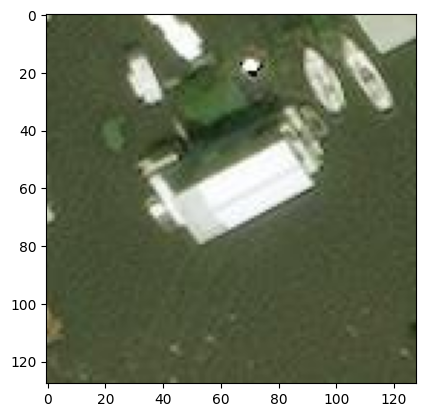

In [2]:
from matplotlib import image
from matplotlib import pyplot

data = image.imread('./data/damage/-93.795_30.03779.jpeg')

print("datatype: ", data.dtype)
print("shape: ", data.shape)

pyplot.imshow(data)
pyplot.show()


Getting the images and labesl in python data types, validating

In [3]:
import numpy as np
import os

# function to get images and labels from folders 

def load_images_from_folder(folder):
    data = []
    labels = []  # 0 for 'no-damage', 1 for 'damage'
    for subfolder in ['no_damage', 'damage']:
        label = 0 if subfolder == 'no_damage' else 1
        path = os.path.join(folder, subfolder)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            try:
                img = Image.open(img_path) 
                img_array = np.array(img)
                data.append(img_array)
                labels.append(label)
            except Exception as e:
                print(e)
    return np.array(data), np.array(labels)


In [4]:
folder = "./data"
data_all, labels_all = load_images_from_folder(folder) ## These hold all the images and labels

In [5]:
import pandas as pd
labels_pd = pd.DataFrame(labels_all, dtype=bool) # converting to a df bc i like the info function
labels_pd.info()
labels_pd.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21322 entries, 0 to 21321
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       21322 non-null  bool 
dtypes: bool(1)
memory usage: 21.0 KB


/var/folders/hm/klr8rtx572v84mlfrf6m6vp80000gn/T/ipykernel_53691/1953387112.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,0
count,21322
unique,2
top,True
freq,14170


In [6]:
print("labels: ", labels_all) # 0 means no damage

labels:  [0 0 0 ... 1 1 1]


In [7]:
print("Number of images: ", data_all.shape[0] )
print("Size of images: ", data_all[0].shape)

Number of images:  21322
Size of images:  (128, 128, 3)


Normalizing data:

In [8]:
def normalize(image_array):
    data_all_resized = []
    for image in data_all:
        image_resized = np.array(image, dtype=np.float32) / 255.0
        img_array = np.array(image_resized)
        data_all_resized.append(img_array)
        
    return np.array(data_all_resized)

In [9]:
data_all_resized = normalize(data_all)

validating all images are the same shape. They are so no need to be rescaled:

In [10]:
# This line finds all the images that are not 128x128 RGB pixels. There are non, all images are same size
data_all_resized[data_all_resized[1].shape != (128, 128, 3)]

array([], shape=(0, 21322, 128, 128, 3), dtype=float32)

Splitting data into testing and training sets

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = data_all_resized
y = labels_all
# y_cat = to_categorical(y, 2)

print(y) # the first number in the array corresponds to damage ...  [damage, no-damage]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

[0 0 0 ... 1 1 1]


In [12]:
# sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15991, 128, 128, 3)
(15991,)
(5331, 128, 128, 3)
(5331,)


### At this point we have:
- loaded the data, visualized it, checked for characteristics such as image size, format, etc.
- put the data into python data types (np.arrays) as the variables data_all and labels_all, which holds all the data.
- Normalized the data
    - didnt need to rescale because all images are the same size
- Split the data into testing and training sets

## Model design, training and evaluation

### ANN

In [13]:
# Flattening the image, 128 px * 128 px * 3 colors (RGB)
image_vector_size = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_train_flattened = X_train.reshape(X_train.shape[0], image_vector_size)
X_test_flattened = X_test.reshape(X_test.shape[0], image_vector_size)

In [14]:
# From class notes:
from tensorflow.keras.callbacks import LambdaCallback
 # Define a callback function to print weights and biases at the end of each epoch
def print_weights_and_biases(epoch, logs):
    if epoch % 1 == 0:  # Print every epoch
        print(f"\nWeights and Biases at the end of Epoch {epoch}:")
        for layer in model.layers:
            print(f"Layer: {layer.name}")
            weights, biases = layer.get_weights()
            print(f"Weights:\n{weights}")
            print(f"Biases:\n{biases}")

# Create a LambdaCallback to call the print_weights_and_biases function
print_weights_callback = LambdaCallback(on_epoch_end=print_weights_and_biases)

Creating Model

In [15]:
# Importing libraries needed for creating neural network,
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# image_vector_size = 128*128*3

Ann = Sequential() # initialize model

# tried having the same number of perceptrons as image size ... didnt work, had memory issues and kernal kept dying
# Ann_1.add(Dense(image_vector_size, activation='relu', input_shape=(image_vector_size,))) 
# models first layer, (128*128*3) perceptrons, relu activation function, input is 1D array of size ((128*128*3), 1)

# first layer
Ann.add(Dense(1028, activation='relu', input_shape=(image_vector_size,)))
# models first layer, 1028 perceptrons, relu activation function, input is 1D array of size ((128*128*3), 1)


Ann.add(Dense(512, activation='relu'))

Ann.add(Dense(256, activation='relu'))

Ann.add(Dense(128, activation='relu'))

Ann.add(Dense(128, activation='relu'))

Ann.add(Dense(64, activation='relu'))

Ann.add(Dense(32, activation='relu'))

Ann.add(Dense(1, activation='sigmoid')) # using sigmoid because its a binary problems
# final layer, 1 perceptrons bc 1 outputs (damage or no damage) this is a binary classification problem


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
Ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1028)           │    50,529,284 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,247,237 (195.49 MB)

 Trainable params: 51,247,237 (195.49 MB)

 Non-trainable params: 0 (0.00 B)

Compiling and training model

- make note we are using the "binary_crossentropy" loss function

In [17]:
Ann_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
Ann_1.fit(X_train_flattened, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=2)

Epoch 1/20


400/400 - 31s - 77ms/step - accuracy: 0.6485 - loss: 0.6962 - val_accuracy: 0.6615 - val_loss: 0.6138
Epoch 2/20
400/400 - 30s - 76ms/step - accuracy: 0.6858 - loss: 0.6019 - val_accuracy: 0.6105 - val_loss: 0.6387
Epoch 3/20
400/400 - 31s - 77ms/step - accuracy: 0.6770 - loss: 0.5810 - val_accuracy: 0.7421 - val_loss: 0.5680
Epoch 4/20
400/400 - 31s - 76ms/step - accuracy: 0.6892 - loss: 0.5864 - val_accuracy: 0.7324 - val_loss: 0.5523
Epoch 5/20
400/400 - 31s - 76ms/step - accuracy: 0.7031 - loss: 0.5848 - val_accuracy: 0.6711 - val_loss: 0.6003
Epoch 6/20
400/400 - 31s - 76ms/step - accuracy: 0.7019 - loss: 0.5911 - val_accuracy: 0.6624 - val_loss: 0.6148
Epoch 7/20
400/400 - 30s - 76ms/step - accuracy: 0.7201 - loss: 0.5695 - val_accuracy: 0.6812 - val_loss: 0.5948
Epoch 8/20
400/400 - 30s - 76ms/step - accuracy: 0.7272 - loss: 0.5677 - val_accuracy: 0.7305 - val_loss: 0.5637
Epoch 9/20
400/400 - 30s - 76ms/step - accuracy: 0.7141 - loss: 0.5761 - val_accuracy: 0.7330 - val_loss: 0

- Note: the accuracy leveled out, maybe i have too many epochs? The validation accuracy is still pretty close though, and the loss is getting smaller so I think its fine

In [ ]:
from tensorflow.keras.models import load_model

if os.path.isfile("./models/Ann.keras"):
    Ann = load_model('./models/Ann.keras')

else: # this takes like an hour to run 
    Ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    Ann.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=2)
    Ann.save("./models/Ann.keras") 

In [18]:
test_loss, test_accuracy = Ann_1.evaluate(X_test_flattened, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.5639902949333191
Test Accuracy: 0.7218157649040222


test accuracy fairly close to training accuracy, thats good ... probably not overfitting

In [19]:
import numpy as np

y_pred = Ann_1.predict(X_test_flattened)
y_pred_flat = [item[0] for item in y_pred]
y_pred_rounded = np.round(y_pred_flat)



167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [20]:
print("Num. of test data points incorrect: ", ((y_pred_rounded == y_test) == False).sum())
print("Num. of test data points correct: ", ((y_pred_rounded == y_test) == True).sum())
print("Total number of testing images: ", len(X_test_flattened))

Num. of test data points incorrect:  1483
Num. of test data points correct:  3848
Total number of testing images:  5331


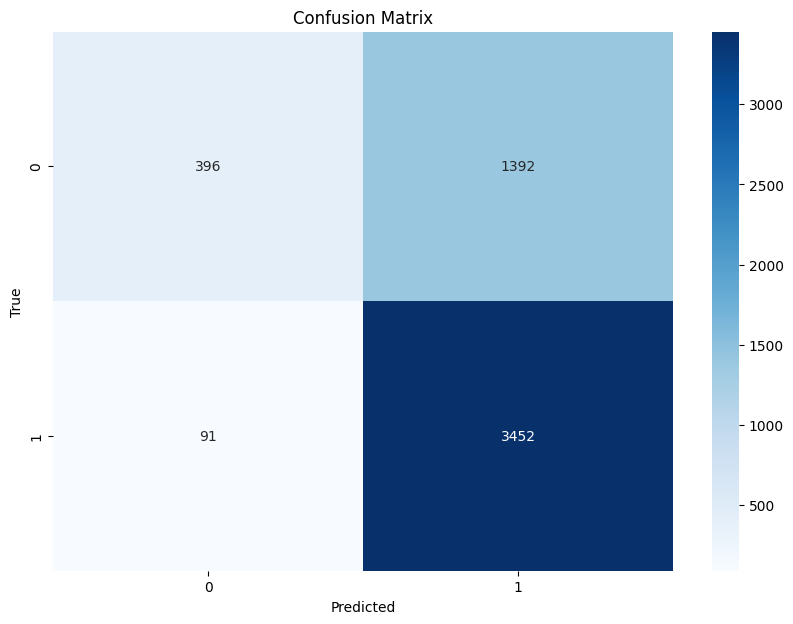

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

^  `1` means damage. We can see that our model incorreclty predicts damage (false positive) more often than it incorrectly predicts no damage.

## Lenet-5 CNN Architecture

In [22]:
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D

lenet5 = Sequential()

input_shape = (128, 128, 3)

# Layer 1: Convolutional layer with 6 filters of size 5x5, followed by average pooling
lenet5.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
lenet5.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 16 filters of size 5x5, followed by average pooling
lenet5.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
lenet5.add(AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
lenet5.add(Flatten())

# Layer 3: Fully connected layer with 120 neurons
lenet5.add(Dense(120, activation='relu'))

# Layer 4: Fully connected layer with 84 neurons
lenet5.add(Dense(84, activation='relu'))

# Output layer: Fully connected layer with num_classes neurons (e.g., 10 for MNIST)
lenet5.add(Dense(1, activation='sigmoid'))

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [23]:
lenet5.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 62, 62, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 29, 29, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 120)            │     1,614,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,961 (6.21 MB)

 Trainable params: 1,627,961 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

Using 8 epochs because this method seems to converge fairly quickly, want to keep accuracy and val_accuracy close

In [24]:
if os.path.isfile("./models/lenet5.keras"):
    lenet5 = load_model('./models/lenet5.keras')

else: # this takes like an hour to run 
    lenet5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lenet5.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=2)
    lenet5.save("./models/lenet5.keras") 

Epoch 1/8


350/350 - 15s - 42ms/step - accuracy: 0.7926 - loss: 0.4609 - val_accuracy: 0.8791 - val_loss: 0.3110
Epoch 2/8
350/350 - 14s - 39ms/step - accuracy: 0.8760 - loss: 0.3046 - val_accuracy: 0.8745 - val_loss: 0.2989
Epoch 3/8
350/350 - 14s - 39ms/step - accuracy: 0.8959 - loss: 0.2630 - val_accuracy: 0.8912 - val_loss: 0.2725
Epoch 4/8
350/350 - 14s - 39ms/step - accuracy: 0.9186 - loss: 0.2148 - val_accuracy: 0.8972 - val_loss: 0.3008
Epoch 5/8
350/350 - 14s - 39ms/step - accuracy: 0.9367 - loss: 0.1714 - val_accuracy: 0.9141 - val_loss: 0.2216
Epoch 6/8
350/350 - 14s - 40ms/step - accuracy: 0.9494 - loss: 0.1378 - val_accuracy: 0.9004 - val_loss: 0.2430
Epoch 7/8
350/350 - 14s - 40ms/step - accuracy: 0.9587 - loss: 0.1079 - val_accuracy: 0.9148 - val_loss: 0.2546
Epoch 8/8
350/350 - 14s - 40ms/step - accuracy: 0.9680 - loss: 0.0847 - val_accuracy: 0.9233 - val_loss: 0.2511


The accuracy is concerningly better than the validation accuracy but I dont think its too bad.

In [25]:
test_loss, test_accuracy = lenet5.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.26436376571655273
Test Accuracy: 0.9191521406173706


In [26]:
y_pred = lenet5.predict(X_test)
y_pred_flat = [item[0] for item in y_pred]
y_pred_rounded = np.round(y_pred_flat)

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


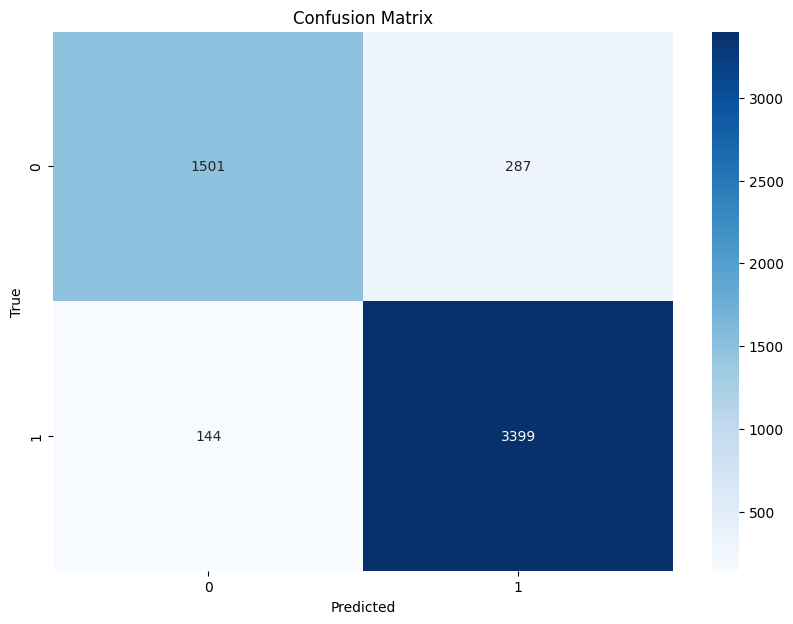

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Alternate-Lenet-5 CNN architecture

In [28]:
from tensorflow.keras.layers import MaxPooling2D, Dropout

alt_lenet = Sequential()

input_shape = (128, 128, 3)

alt_lenet.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
alt_lenet.add(MaxPooling2D((2, 2)))

alt_lenet.add(Conv2D(64, (3, 3), activation='relu'))
alt_lenet.add(MaxPooling2D((2, 2)))

alt_lenet.add(Conv2D(128, (3, 3), activation='relu'))
alt_lenet.add(MaxPooling2D((2, 2)))

alt_lenet.add(Conv2D(128, (3, 3), activation='relu'))
alt_lenet.add(MaxPooling2D((2, 2)))

alt_lenet.add(Flatten())

alt_lenet.add(Dropout(0.5))  # dropout rate is 0.5

alt_lenet.add(Dense(512, activation='relu'))
alt_lenet.add(Dense(1, activation='sigmoid'))

alt_lenet.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,153 (9.92 MB)

 Trainable params: 2,601,153 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
alt_lenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
alt_lenet.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=32, verbose=2) 

Epoch 1/10


350/350 - 34s - 98ms/step - accuracy: 0.7951 - loss: 0.4319 - val_accuracy: 0.9139 - val_loss: 0.1989
Epoch 2/10
350/350 - 34s - 96ms/step - accuracy: 0.9292 - loss: 0.1876 - val_accuracy: 0.9431 - val_loss: 0.1496
Epoch 3/10
350/350 - 34s - 97ms/step - accuracy: 0.9459 - loss: 0.1427 - val_accuracy: 0.9491 - val_loss: 0.1530
Epoch 4/10
350/350 - 34s - 99ms/step - accuracy: 0.9543 - loss: 0.1223 - val_accuracy: 0.9527 - val_loss: 0.1120
Epoch 5/10
350/350 - 34s - 98ms/step - accuracy: 0.9557 - loss: 0.1144 - val_accuracy: 0.9535 - val_loss: 0.1219
Epoch 6/10
350/350 - 34s - 98ms/step - accuracy: 0.9625 - loss: 0.1005 - val_accuracy: 0.9667 - val_loss: 0.1017
Epoch 7/10
350/350 - 34s - 97ms/step - accuracy: 0.9693 - loss: 0.0816 - val_accuracy: 0.9516 - val_loss: 0.1286
Epoch 8/10
350/350 - 33s - 94ms/step - accuracy: 0.9715 - loss: 0.0724 - val_accuracy: 0.9689 - val_loss: 0.0816
Epoch 9/10
350/350 - 34s - 96ms/step - accuracy: 0.9746 - loss: 0.0663 - val_accuracy: 0.9673 - val_loss: 0

In [81]:
if os.path.isfile("./models/alt_lenet.keras"):
    alt_lenet = load_model('./models/alt_lenet.keras')

else: # this takes like an hour to run 
    alt_lenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    alt_lenet.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=32, verbose=2) 
    alt_lenet.save("./models/alt_lenet.keras") 

Epoch 1/10


KeyboardInterrupt: 

In [30]:
test_loss, test_accuracy = alt_lenet.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.1062389612197876
Test Accuracy: 0.9673607349395752


In [31]:
y_pred = lenet5.predict(X_test)
y_pred_flat = [item[0] for item in y_pred]
y_pred_rounded = np.round(y_pred_flat)

  5/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


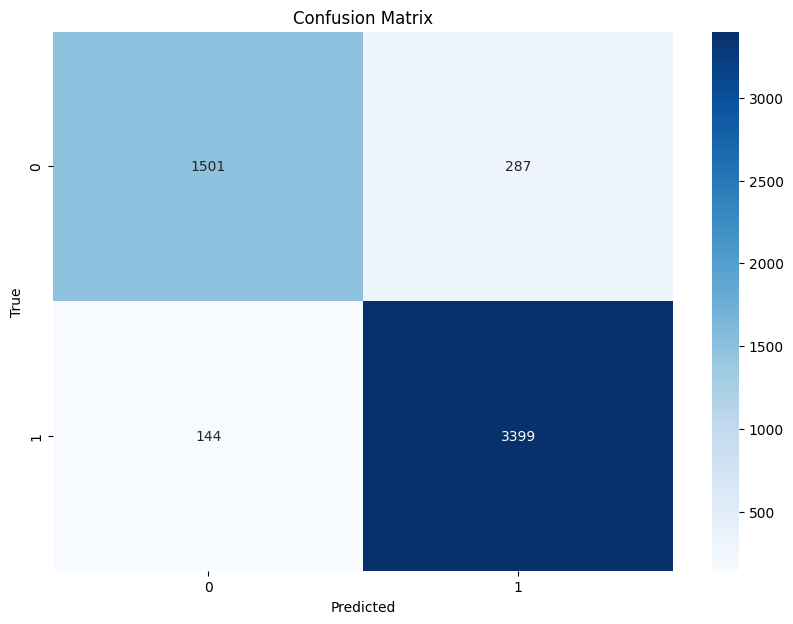

In [32]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Inception (GoogLeNet) model
https://arxiv.org/pdf/1409.4842.pdf


In [33]:
from tensorflow.keras.applications.inception_v3  import InceptionV3

inception_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape= (299, 299, 3),    #(299, 299, 3),
    pooling="max",
    classes=1,
    classifier_activation="sigmoid",
)

for layer in inception_model.layers:
    layer.trainable = False

inception_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [34]:
from tensorflow.keras.layers import Resizing


my_inception = Sequential()

my_inception.add(Resizing(height=299, width=299)) # inception needs 299x299 images

my_inception.add(inception_model)
# my_inception.add(Flatten())

my_inception.add(Dense(32, activation='relu'))
my_inception.add(Dropout(0.2))
my_inception.add(Dense(32, activation='relu'))

my_inception.add(Dense(1, activation='sigmoid'))

In [35]:
# inception_model.summary() # big

my_inception.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [36]:
from tensorflow.keras.models import load_model

if os.path.isfile("./models/inception.keras"):
    my_inception = load_model('./models/inception.keras')

else: # this takes like an hour to run 
    my_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    my_inception.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=32, verbose=2)
    my_inception.save("./models/inception.keras") 

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_1126>'],)
  • kwargs=<class 'inspect._empty'>

In [ ]:
test_loss, test_accuracy = my_inception.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.18192514777183533
Test Accuracy: 0.9215906858444214


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


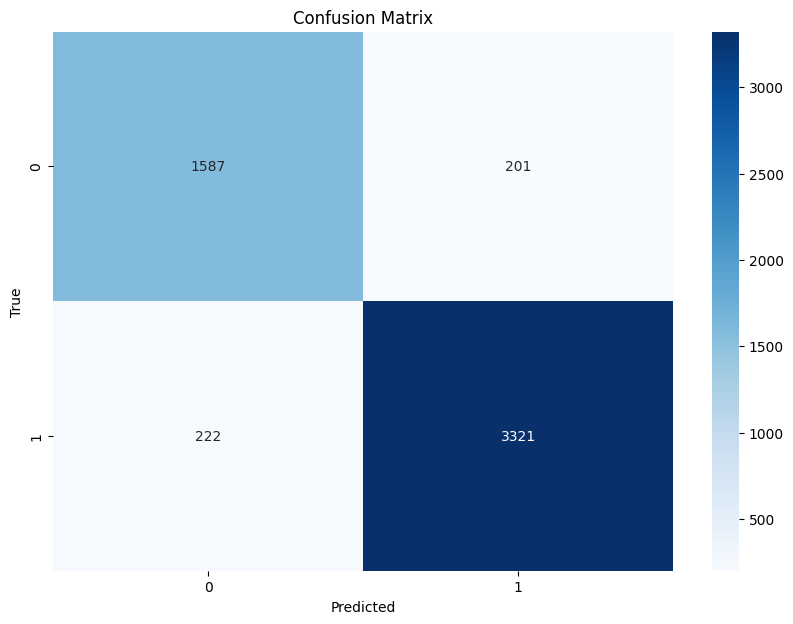

In [ ]:
y_pred = lenet5.predict(X_test)
y_pred_flat = [item[0] for item in y_pred]
y_pred_rounded = np.round(y_pred_flat)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## VGG 16 

In [ ]:
from keras.applications.vgg16 import VGG16

vgg_model_base = VGG16(weights='imagenet', include_top = False, input_shape=input_shape)
vgg_model_base.summary()

for layer in vgg_model_base.layers:
    layer.trainable = False

# Initializing the model
vgg_model = Sequential()

vgg_model.add(vgg_model_base)

vgg_model.add(Flatten())

vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.2))

vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dense(32, activation='relu'))
vgg_model.add(Dropout(0.2))

# Adding output layer
vgg_model.add(Dense(1, activation='sigmoid'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vgg_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compiling the model

import os.path
from tensorflow.keras.models import load_model

if os.path.isfile("./models/vgg.keras"):
    vgg_model = load_model('./models/vgg.keras')
else:
    vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    vgg_model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=32, verbose=2) 
    vgg_model.save("./models/inception.keras")

Epoch 1/10
350/350 - 196s - 559ms/step - accuracy: 0.9413 - loss: 0.1535 - val_accuracy: 0.9246 - val_loss: 0.1922
Epoch 2/10
350/350 - 196s - 561ms/step - accuracy: 0.9499 - loss: 0.1306 - val_accuracy: 0.9379 - val_loss: 0.1734
Epoch 3/10
350/350 - 192s - 550ms/step - accuracy: 0.9574 - loss: 0.1106 - val_accuracy: 0.9398 - val_loss: 0.1580
Epoch 4/10
350/350 - 196s - 559ms/step - accuracy: 0.9622 - loss: 0.0957 - val_accuracy: 0.9321 - val_loss: 0.1844
Epoch 5/10
350/350 - 191s - 546ms/step - accuracy: 0.9681 - loss: 0.0832 - val_accuracy: 0.9389 - val_loss: 0.1668
Epoch 6/10
350/350 - 192s - 549ms/step - accuracy: 0.9719 - loss: 0.0702 - val_accuracy: 0.9346 - val_loss: 0.2711
Epoch 7/10
350/350 - 194s - 554ms/step - accuracy: 0.9769 - loss: 0.0608 - val_accuracy: 0.9441 - val_loss: 0.1839
Epoch 8/10
350/350 - 194s - 553ms/step - accuracy: 0.9788 - loss: 0.0558 - val_accuracy: 0.9312 - val_loss: 0.2684
Epoch 9/10
350/350 - 195s - 558ms/step - accuracy: 0.9821 - loss: 0.0446 - val_a

In [ ]:
test_loss, test_accuracy = vgg_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.3154551684856415
Test Accuracy: 0.9367848634719849


167/167 ━━━━━━━━━━━━━━━━━━━━ 64s 382ms/step


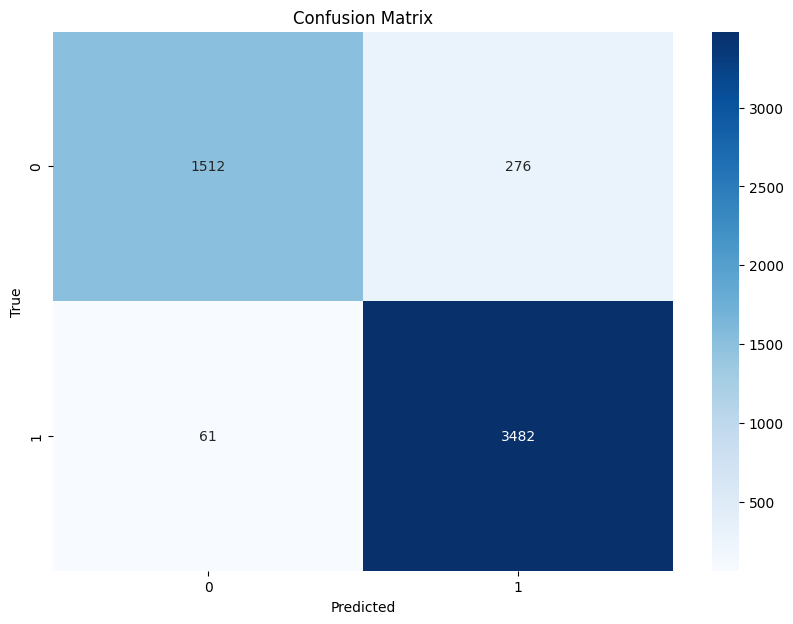

In [ ]:
y_pred = vgg_model.predict(X_test)
y_pred_flat = [item[0] for item in y_pred]
y_pred_rounded = np.round(y_pred_flat)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### ResNet
- this didnt work very well, maybe try changing "include_top" back to true adn tehn resizing the image in teh model and makign the "input_shape" default

In [78]:
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(    
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=1,
    classifier_activation="softmax",
)


# resnet_base.summary()

for layer in resnet_base.layers:
    layer.trainable = False

resnet = Sequential()
resnet.add(resnet_base)
# resnet.add(Flatten())

resnet.add(Dense(256, activation='relu'))
resnet.add(Dropout(0.2))
resnet.add(Dense(128, activation='relu'))
resnet.add(Dropout(0.2))
resnet.add(Dense(64, activation='relu'))

# Adding output layer
resnet.add(Dense(1, activation='sigmoid'))

In [40]:
# Compiling the model
if os.path.isfile("./models/resnet.keras"):
    resnet = load_model('./models/resnet.keras')
else:
    resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    resnet.fit(X_train, y_train, validation_split=0.3, epochs=20, batch_size=128, verbose=2) 
    resnet.save("./models/resnet.keras")

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 4, 4, 2048), dtype=float32, sparse=False, name=keras_tensor_2224>'],)
  • kwargs=<class 'inspect._empty'>

In [80]:
resnet.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Xception 

In [67]:
from tensorflow.keras.applications import Xception

xception_base = Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(299, 299, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


# resnet_base.summary()

for layer in xception_base.layers:
    layer.trainable = False

xception = Sequential()
xception.add(Resizing(width=299, height=299))
xception.add(xception_base)
# xception.add(Flatten()) 
# Dont need this layer because Xception ends with a flatten layer


xception.add(Dense(128, activation='relu'))
xception.add(Dropout(0.2))
xception.add(Dense(128, activation='relu'))

# Adding output layer
xception.add(Dense(1, activation='sigmoid'))

In [68]:
xception.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ ?                      │    22,910,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,910,480 (87.40 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 22,910,480 (87.40 MB)

In [43]:
# Compiling the model
if os.path.isfile("./models/xception.keras"):
    xception = load_model('./models/xception.keras')
else:
    xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    xception.fit(X_train, y_train, validation_split=0.3, epochs=20, batch_size=128, verbose=2) 
    xception.save("./models/xception.keras")

Epoch 1/20
88/88 - 408s - 5s/step - accuracy: 0.7455 - loss: 0.5186 - val_accuracy: 0.8372 - val_loss: 0.3830
Epoch 2/20
88/88 - 404s - 5s/step - accuracy: 0.8565 - loss: 0.3467 - val_accuracy: 0.8693 - val_loss: 0.3168
Epoch 3/20
88/88 - 404s - 5s/step - accuracy: 0.8770 - loss: 0.2967 - val_accuracy: 0.8795 - val_loss: 0.2944
Epoch 4/20
88/88 - 401s - 5s/step - accuracy: 0.8869 - loss: 0.2765 - val_accuracy: 0.8877 - val_loss: 0.2751
Epoch 5/20
88/88 - 404s - 5s/step - accuracy: 0.8996 - loss: 0.2501 - val_accuracy: 0.8960 - val_loss: 0.2582
Epoch 6/20
88/88 - 404s - 5s/step - accuracy: 0.9030 - loss: 0.2386 - val_accuracy: 0.8977 - val_loss: 0.2504
Epoch 7/20
88/88 - 401s - 5s/step - accuracy: 0.9075 - loss: 0.2259 - val_accuracy: 0.9035 - val_loss: 0.2405
Epoch 8/20
88/88 - 402s - 5s/step - accuracy: 0.9132 - loss: 0.2170 - val_accuracy: 0.9035 - val_loss: 0.2392
Epoch 9/20
88/88 - 401s - 5s/step - accuracy: 0.9171 - loss: 0.2070 - val_accuracy: 0.9054 - val_loss: 0.2362
Epoch 10/2

In [48]:
test_loss, test_accuracy = xception.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.24419918656349182
Test Accuracy: 0.9131494760513306
